In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from os import listdir
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from PIL import Image as PImage

import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# For local testing, copy and paste the directory where your data is.
train_path = "/home/jgoh4/card_clf/train/"
data_dir_train = pathlib.Path(train_path).with_suffix('')
val_path = "/home/jgoh4/card_clf/valid/"
data_dir_val = pathlib.Path(val_path).with_suffix('')
test_path = "/home/jgoh4/card_clf/train/"
data_dir_test = pathlib.Path(test_path).with_suffix('')

print(data_dir_train)

2023-12-07 18:13:54.832410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/jgoh4/card_clf/train


In [2]:
image_count = len(list(data_dir_train.glob('*/*.jpg')))
print("Image Count: ", image_count)

Image Count:  7624


In [3]:
# Here we read the .png images into a dataset (non-tabular, presumably) formatted as tensors
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  image_size = (224,224),
  batch_size = 32)

# Here we read the .png images into a dataset (non-tabular, presumably) formatted as tensors
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_val,
    image_size = (224,224),
    batch_size = 32
)

# read test images
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    image_size = (224,224),
    batch_size = 32
)

class_names = train_ds.class_names
print(class_names) # same as labels
num_classes = len(class_names)


Found 7624 files belonging to 53 classes.


2023-12-07 18:14:01.194871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 18:14:01.819172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78962 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


Found 265 files belonging to 53 classes.
Found 7624 files belonging to 53 classes.
['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of dia

In [4]:
# Some kind of optimization - reduces training time
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import BatchNormalization

## Transfer Learning with ResNet50

In [6]:
base_model = keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
    pooling = max
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Data augmentation - necessary for addressing overfitting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Create new model on top
# inputs = keras.Input(shape=(224, 224, 3))

"""
# Re-scale
scale_layer = keras.layers.Rescaling(scale=1./255, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)
"""
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    base_model,
    BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation = 'softmax') # this line MUST correspond to the number of classes/labels, else it crashes
])



In [7]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', #SparseCategoricalCrossentropy exclusively for integer-labeled
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)             

In [9]:
epochs = 20
res_hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20


2023-12-05 01:47:16.343300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-12-05 01:47:17.092985: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-05 01:47:17.150115: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


239/239 [==============================] - 12s 20ms/step - loss: 3.3001 - accuracy: 0.1891 - val_loss: 3.0539 - val_accuracy: 0.2868
Epoch 2/20
239/239 [==============================] - 4s 15ms/step - loss: 2.6761 - accuracy: 0.3446 - val_loss: 2.4418 - val_accuracy: 0.3887
Epoch 3/20
239/239 [==============================] - 4s 15ms/step - loss: 2.3671 - accuracy: 0.4234 - val_loss: 2.1332 - val_accuracy: 0.4792
Epoch 4/20
239/239 [==============================] - 4s 15ms/step - loss: 2.1500 - accuracy: 0.4757 - val_loss: 2.0235 - val_accuracy: 0.5132
Epoch 5/20
239/239 [==============================] - 4s 15ms/step - loss: 1.9905 - accuracy: 0.5153 - val_loss: 1.9308 - val_accuracy: 0.5321
Epoch 6/20
239/239 [==============================] - 4s 15ms/step - loss: 1.8640 - accuracy: 0.5460 - val_loss: 1.8586 - val_accuracy: 0.5321
Epoch 7/20
239/239 [==============================] - 4s 15ms/step - loss: 1.7535 - accuracy: 0.5727 - val_loss: 1.8592 - val_accuracy: 0.5283
Epoch 8/2

In [10]:
# Without finetuning, overfitting with increaseing epochs. Peak at 60%
# Fine-tune model. Unfreeze base model, train end-to-end with low learning rate
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy', #SparseCategoricalCrossentropy exclusively for integer-labeled
    metrics=['accuracy'])

epochs = 20
res_hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)             

In [11]:
# save 'model history' as a dictionary
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(res_hist.history, file_pi)

PermissionError: [Errno 13] Permission denied: '/trainHistoryDict'

In [ ]:
# load history. for plotting loss/accuracy
with open('/trainHistoryDict', "rb") as file_pi:
    res_history_load = pickle.load(file_pi)

20


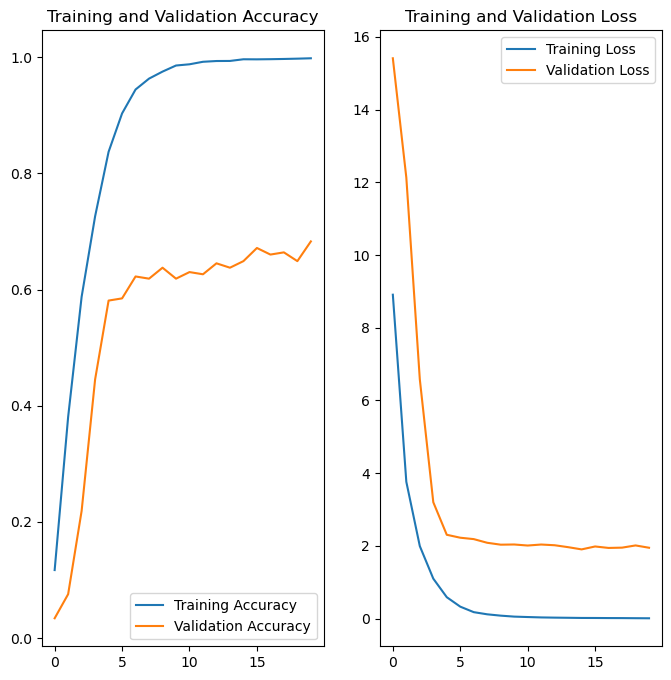

In [12]:
acc = res_hist.history['accuracy']
val_acc = res_hist.history['val_accuracy']
print(len(acc))
loss = res_hist.history['loss']
val_loss = res_hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
# With fine-tuning, our validation accuracy plataues


In [ ]:
# with fine-tuning, we see diminishing returns in validation loss. Other methods must be utilized to address this overfit
# Consider hypermodel for ResNet


## HyperModel, based on GridSearch

In [6]:
import keras_tuner as kt
from keras_tuner.applications import HyperResNet

In [7]:
tuner_gs = kt.GridSearch(HyperResNet(include_top = False, input_shape=(224, 224, 3), classes=num_classes),
                     objective='val_accuracy',
                     max_trials=20, max_consecutive_failed_trials = 5)

Reloading Tuner from ./untitled_project/tuner0.json


In [8]:
# Create a callback to stop training early after reaching a certain value for the validation loss. If no improvement of val_loss within 5 epochs, stop.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
# Run hyperparamater search!
# Same arguments as in model.fit
tuner_gs.search(train_ds, epochs=50, validation_data = val_ds, callbacks=[stop_early])
# Get the optimal hyperparameters
best_hps_hyp_gs=tuner_gs.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search (using HyperResNet) is complete. {best_hps_hyp_gs.values}
""")





The hyperparameter search (using HyperResNet) is complete. {'version': 'v2', 'conv3_depth': 4, 'conv4_depth': 6, 'pooling': 'avg', 'optimizer': 'adam', 'learning_rate': 0.001}



In [20]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_gs.hypermodel.build(best_hps_hyp_gs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps_hyp_gs.get('learning_rate')),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
history_hp_hyp_gs = model.fit(train_ds, epochs=50, validation_data=val_ds)


val_acc_per_epoch = history_hp_hyp_gs.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50


2023-12-07 18:24:41.556982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-12-07 18:24:47.514312: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-07 18:24:48.093958: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


239/239 [==============================] - 27s 48ms/step - loss: 6.2392 - accuracy: 0.1272 - val_loss: 5.8682 - val_accuracy: 0.0981
Epoch 2/50
239/239 [==============================] - 10s 42ms/step - loss: 5.0818 - accuracy: 0.2315 - val_loss: 5.7359 - val_accuracy: 0.0830
Epoch 3/50
239/239 [==============================] - 10s 41ms/step - loss: 4.3152 - accuracy: 0.2933 - val_loss: 5.2067 - val_accuracy: 0.1660
Epoch 4/50
239/239 [==============================] - 10s 42ms/step - loss: 3.7167 - accuracy: 0.3615 - val_loss: 3.2226 - val_accuracy: 0.2604
Epoch 5/50
239/239 [==============================] - 10s 41ms/step - loss: 3.1697 - accuracy: 0.4334 - val_loss: 3.1604 - val_accuracy: 0.4000
Epoch 6/50
239/239 [==============================] - 10s 42ms/step - loss: 2.7476 - accuracy: 0.4807 - val_loss: 2.5376 - val_accuracy: 0.4679
Epoch 7/50
239/239 [==============================] - 10s 42ms/step - loss: 2.3854 - accuracy: 0.5414 - val_loss: 2.4351 - val_accuracy: 0.4830
Epo

In [23]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner_gs.hypermodel.build(best_hps_hyp_gs)
hypermodel.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps_hyp_gs.get('learning_rate')),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Retrain the model
final_hist_hyp_gs = hypermodel.fit(train_ds, epochs=best_epoch, validation_data = val_ds)



Epoch 1/32
239/239 [==============================] - 13s 43ms/step - loss: 6.2046 - accuracy: 0.1403 - val_loss: 13.2003 - val_accuracy: 0.0302
Epoch 2/32
239/239 [==============================] - 10s 41ms/step - loss: 5.0901 - accuracy: 0.2281 - val_loss: 6.7965 - val_accuracy: 0.0491
Epoch 3/32
239/239 [==============================] - 10s 41ms/step - loss: 4.2955 - accuracy: 0.2926 - val_loss: 3.2618 - val_accuracy: 0.3585
Epoch 4/32
239/239 [==============================] - 10s 41ms/step - loss: 3.7139 - accuracy: 0.3498 - val_loss: 3.5947 - val_accuracy: 0.2717
Epoch 5/32
239/239 [==============================] - 10s 41ms/step - loss: 3.1901 - accuracy: 0.4218 - val_loss: 4.2741 - val_accuracy: 0.2113
Epoch 6/32
239/239 [==============================] - 10s 41ms/step - loss: 2.7229 - accuracy: 0.4887 - val_loss: 1.8999 - val_accuracy: 0.5660
Epoch 7/32
239/239 [==============================] - 10s 41ms/step - loss: 2.3089 - accuracy: 0.5771 - val_loss: 2.0587 - val_accuracy

NameError: name 'epochs' is not defined

32


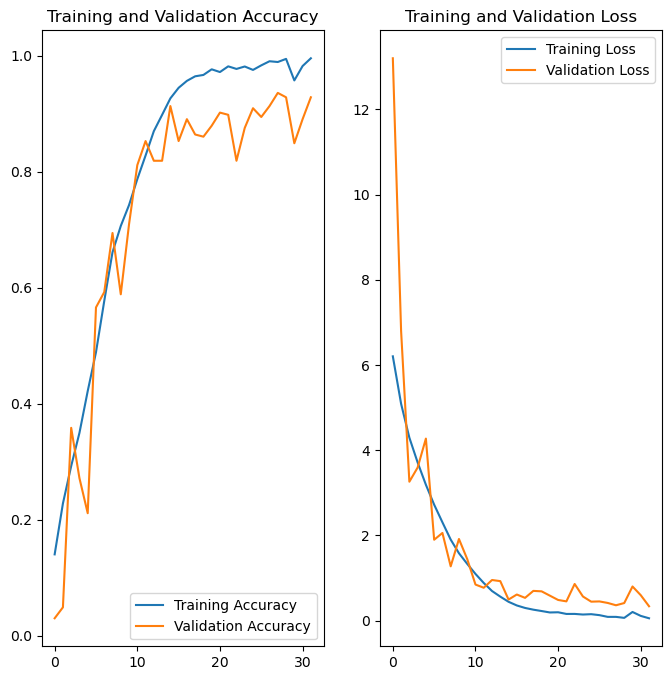

In [24]:
acc = final_hist_hyp_gs.history['accuracy']
val_acc = final_hist_hyp_gs.history['val_accuracy']
print(len(acc))
loss = final_hist_hyp_gs.history['loss']
val_loss = final_hist_hyp_gs.history['val_loss']

epochs_range = range(best_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
eval_result = hypermodel.evaluate(test_ds)
print("[test loss, test accuracy]:", eval_result)

239/239 [==============================] - 4s 17ms/step - loss: 0.0527 - accuracy: 0.9871
[test loss, test accuracy]: [0.05265914276242256, 0.9871458411216736]


## HyperModel, based on RandomSearch

In [50]:
tuner_rs = kt.RandomSearch(HyperResNet(include_top = False, input_shape=(224, 224, 3), classes=num_classes),
                     objective='val_accuracy',
                     max_trials=20, max_consecutive_failed_trials = 200, max_retries_per_trial = 10) #force trials to run to completion

Reloading Tuner from ./untitled_project/tuner0.json


In [51]:
# Create a callback to stop training early after reaching a certain value for the validation loss. If no improvement of val_loss within 5 epochs, stop.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [52]:
# Run hyperparamater search!
# Same arguments as in model.fit

tuner_rs.search(train_ds, epochs=50, validation_data = val_ds, callbacks=[stop_early])
# Get the optimal hyperparameters
best_hps_hyp_rs=tuner_rs.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search (using HyperResNet) is complete. {best_hps_hyp_rs.values}
""")



Trial 20 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 04h 53m 42s

The hyperparameter search (using HyperResNet) is complete. {'version': 'v1', 'conv3_depth': 4, 'conv4_depth': 36, 'pooling': 'avg', 'optimizer': 'sgd', 'learning_rate': 0.1}



In [53]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# We search for the best epoch, with the best measures.
model = tuner_rs.hypermodel.build(best_hps_hyp_rs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps_hyp_rs.get('learning_rate')),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
history_hp_hyp_rs = model.fit(train_ds, epochs=50, validation_data=val_ds)


val_acc_per_epoch = history_hp_hyp_rs.history['val_accuracy']
best_val_acc = max(val_acc_per_epoch)
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
239/239 [==============================] - 34s 105ms/step - loss: 4.6444 - accuracy: 0.0501 - val_loss: 80.3757 - val_accuracy: 0.0000e+00
Epoch 2/50
239/239 [==============================] - 23s 96ms/step - loss: 3.3555 - accuracy: 0.1762 - val_loss: 6.8624 - val_accuracy: 0.1057
Epoch 3/50
239/239 [==============================] - 24s 99ms/step - loss: 2.7122 - accuracy: 0.2836 - val_loss: 4.9408 - val_accuracy: 0.1358
Epoch 4/50
239/239 [==============================] - 24s 101ms/step - loss: 2.4266 - accuracy: 0.3717 - val_loss: 12.7961 - val_accuracy: 0.1170
Epoch 5/50
239/239 [==============================] - 24s 101ms/step - loss: 2.1455 - accuracy: 0.4620 - val_loss: 7.3751 - val_accuracy: 0.1019
Epoch 6/50
239/239 [==============================] - 24s 100ms/step - loss: 1.8681 - accuracy: 0.5518 - val_loss: 6.1565 - val_accuracy: 0.3094
Epoch 7/50
239/239 [==============================] - 24s 100ms/step - loss: 1.6756 - accuracy: 0.5989 - val_loss: 2.1631 - va

In [54]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel_rs = tuner_rs.hypermodel.build(best_hps_hyp_rs)
hypermodel_rs.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps_hyp_rs.get('learning_rate')),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Retrain the model
final_hist_hyp_rs = hypermodel_rs.fit(train_ds, epochs=best_epoch, validation_data = val_ds)


Epoch 1/45
239/239 [==============================] - 35s 107ms/step - loss: 4.6554 - accuracy: 0.0470 - val_loss: 19238.4219 - val_accuracy: 0.0000e+00
Epoch 2/45
239/239 [==============================] - 24s 100ms/step - loss: 3.6611 - accuracy: 0.1327 - val_loss: 49.3472 - val_accuracy: 0.0340
Epoch 3/45
239/239 [==============================] - 24s 100ms/step - loss: 3.1834 - accuracy: 0.2219 - val_loss: 9.7791 - val_accuracy: 0.0566
Epoch 4/45
239/239 [==============================] - 24s 101ms/step - loss: 2.8172 - accuracy: 0.2971 - val_loss: 3.5670 - val_accuracy: 0.2453
Epoch 5/45
239/239 [==============================] - 23s 98ms/step - loss: 2.5289 - accuracy: 0.3986 - val_loss: 4.1538 - val_accuracy: 0.2453
Epoch 6/45
239/239 [==============================] - 23s 96ms/step - loss: 2.2205 - accuracy: 0.4873 - val_loss: 6.3383 - val_accuracy: 0.1811
Epoch 7/45
239/239 [==============================] - 23s 96ms/step - loss: 1.9008 - accuracy: 0.5584 - val_loss: 4.0487 - 

45


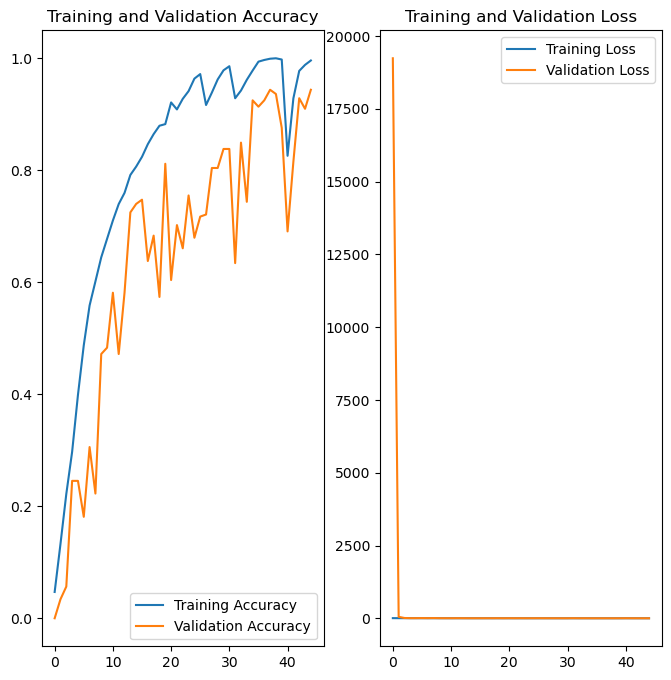

In [59]:
acc = final_hist_hyp_rs.history['accuracy']
val_acc = final_hist_hyp_rs.history['val_accuracy']
print(len(acc))
loss = final_hist_hyp_rs.history['loss']
val_loss = final_hist_hyp_rs.history['val_loss']

epochs_range = range(best_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
best_val_acc = max(val_acc_per_epoch)
print(best_val_acc)

0.9584905505180359


In [61]:
print(val_loss)

[19238.421875, 49.34721374511719, 9.779139518737793, 3.5670363903045654, 4.153811454772949, 6.338341236114502, 4.048731327056885, 6.7021331787109375, 2.8964850902557373, 2.3589112758636475, 1.956958293914795, 3.1449942588806152, 2.4889564514160156, 1.3746660947799683, 1.3719632625579834, 1.2791045904159546, 1.6654750108718872, 1.5575944185256958, 2.7601399421691895, 0.945551335811615, 2.5176939964294434, 1.3853909969329834, 2.1838972568511963, 0.9869624376296997, 1.717570424079895, 2.254672050476074, 1.4640387296676636, 0.9703810214996338, 1.0205063819885254, 0.6584292650222778, 0.5578811764717102, 2.8216428756713867, 0.7023236155509949, 1.6246311664581299, 0.3892669975757599, 0.31965959072113037, 0.38308537006378174, 0.25823670625686646, 0.30876436829566956, 0.7758459448814392, 2.0019819736480713, 0.8666766285896301, 0.4176035523414612, 0.4196210205554962, 0.23262417316436768]


In [62]:
eval_result = hypermodel_rs.evaluate(test_ds)
print("[test loss, test accuracy]:", eval_result)

239/239 [==============================] - 13s 50ms/step - loss: 0.0275 - accuracy: 0.9919
[test loss, test accuracy]: [0.027490193024277687, 0.9918677806854248]
